# 🌌 Jet Protoestelar

Barbara Chassoul  
UCR, FS1039 - Tarea Programada II

**Git**: [FS1039-T2](https://github.com/bchassoul/FS1039-T2)

In [37]:
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT / "src"))
sys.path.append(str(PROJECT_ROOT))

from src.config import G, M_STAR, AU_CM, CM_KM
from src.utils import (
    load_simulation,
    calculate_region_stats,
    find_min_step,
    order_of_magnitude
)

data = load_simulation()
x, z, vr, rho, Pgrad_r, PBgrad_r, table = (
    data["x"], data["z"], data["vr"], data["rho"],
    data["Pgrad_r"], data["PBgrad_r"], data["table"]
)


✨ Data loaded successfully!


## ⭐ Problema 1: Velocidad radial

### 1.1 Graficar velocidad radial
Graficar la velocidad radial en km/s usando `pcolormesh` con el colormap `seismic_r`, de modo que valores negativos se muestren en rojo, positivos en azul y valores cercanos a cero en blanco.

### 1.2 Identificar regiones
Identificar las tres regiones principales del sistema basándose en la velocidad radial:
- Jet
- Disco de acreción
- Infall

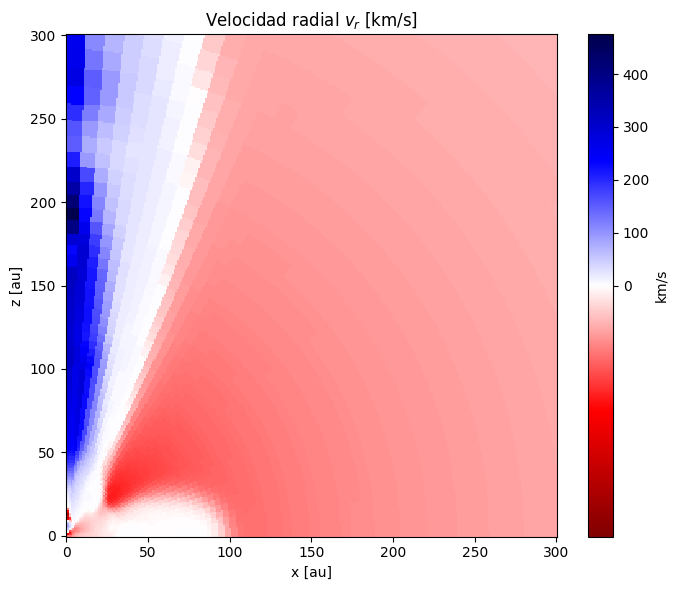

In [38]:
# Convert velocity from cm/s to km/s
vr_kms = vr * CM_KM

# Normalization for colormap: red for negative, white at 0, blue for positive
vmax = np.nanmax(vr_kms)
vmin = np.nanmin(vr_kms)
vnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot radial velocity
fig, ax = plt.subplots(figsize=(7, 6))
pc = ax.pcolormesh(x, z, vr_kms, shading="auto", cmap="seismic_r", norm=vnorm)
ax.set_xlabel("x [au]")
ax.set_ylabel("z [au]")
ax.set_title(r"Velocidad radial $v_r$ [km/s]")
cbar = fig.colorbar(pc, ax=ax)
cbar.set_label("km/s")
plt.tight_layout()
plt.show()




### Criterio de identificación

Para identificar las tres regiones, se utiliza un umbral de velocidad radial de ±0.5 km/s:

- Jet: Material eyectado desde el disco de acreción, flujo hacia afuera con `v_r > 0.5 km/s`.
- Disco: Material que rota alrededor de la protoestrella con movimiento principalmente tangencial, movimiento radial casi nulo con `|v_r| ≤ 0.5 km/s`. 
- Infall: Material de la nube circundante que cae hacia el sistema, coolapso hacia adentro con `v_r < -0.5 km/s`.


El umbral de 0.5 km/s se eligió para separar estas tres regiones físicas, evitando que el material en rotación del disco sea clasificado como jet o infall.


In [39]:
# Define threshold to classify regions based on radial velocity
eps_kms = 0.5  # km/s

# Create boolean masks for each region
mask_jet    = vr_kms >  eps_kms   # outflow
mask_infall = vr_kms < -eps_kms   # infall
mask_disc   = np.abs(vr_kms) <= eps_kms  # almost no radial motion

total_puntos = np.isfinite(vr_kms).sum()

# Calculate statistics using utils function
stats_jet = calculate_region_stats(mask_jet, vr_kms, total_points=total_puntos, percentiles=[0, 50, 100])
stats_infall = calculate_region_stats(mask_infall, vr_kms, total_points=total_puntos, percentiles=[0, 50, 100])
stats_disc = calculate_region_stats(mask_disc, vr_kms, total_points=total_puntos, percentiles=[0, 50, 100])

print(f"✨ jet    -> área: {stats_jet['area_pct']:6.2f}% | v_med: {stats_jet['median']:7.3f} km/s | v_max: {stats_jet['p100']:7.3f} km/s | v_min: {stats_jet['p0']:7.3f} km/s")
print(f"✨ infall -> área: {stats_infall['area_pct']:6.2f}% | v_med: {stats_infall['median']:7.3f} km/s | v_max: {stats_infall['p100']:7.3f} km/s | v_min: {stats_infall['p0']:7.3f} km/s")
print(f"✨ disco  -> área: {stats_disc['area_pct']:6.2f}% | v_med: {stats_disc['median']:7.3f} km/s | v_max: {stats_disc['p100']:7.3f} km/s | v_min: {stats_disc['p0']:7.3f} km/s")

✨ jet    -> área:  17.75% | v_med:  43.038 km/s | v_max: 475.026 km/s | v_min:   0.507 km/s
✨ infall -> área:  80.89% | v_med:  -4.374 km/s | v_max:  -0.507 km/s | v_min: -23.573 km/s
✨ disco  -> área:   1.35% | v_med:  -0.120 km/s | v_max:   0.468 km/s | v_min:  -0.499 km/s


## ⭐ Problema 2: Densidad

### 2.1 Graficar logaritmo de densidad
Graficar el logaritmo en base 10 de la densidad usando `pcolormesh`.

### 2.2 Identificar densidades típicas
Usando las regiones identificadas en el Problema 1, calcular y reportar las densidades típicas del jet y del disco de acreción.


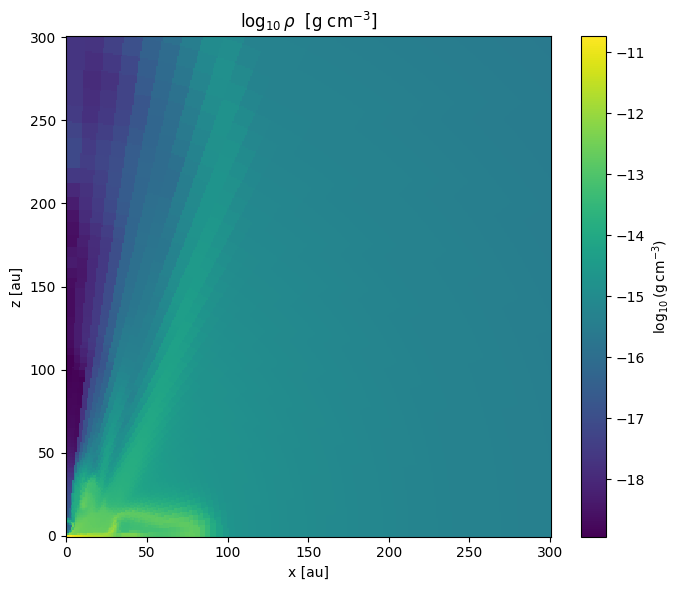

In [40]:
log10_rho = np.log10(rho)

rho_min = float(np.nanmin(log10_rho))
rho_max = float(np.nanmax(log10_rho))

# Plot logarithm of density
fig, ax = plt.subplots(figsize=(7, 6))
pc = ax.pcolormesh(x, z, log10_rho, shading='auto', cmap='viridis', vmin=rho_min, vmax=rho_max)
ax.set_xlabel('x [au]')
ax.set_ylabel('z [au]')
ax.set_title(r'$\log_{10}\rho$  [g cm$^{-3}$]')
cbar = fig.colorbar(pc, ax=ax)
cbar.set_label(r'$\log_{10}(\mathrm{g\,cm^{-3}})$')
plt.tight_layout()
plt.show()

In [41]:
# Calculate density statistics using utils function with log_stats
dens_jet = calculate_region_stats(mask_jet, rho, return_log_stats=True)
dens_disc = calculate_region_stats(mask_disc, rho, return_log_stats=True)

def format_density_stats(s):
    return (f"n={s['n']:6d} | "
            f"log10ρ_med={s['log10_med']:.3f}  "
            f"[{s['log10_p25']:.3f}, {s['log10_p75']:.3f}]  |  "
            f"ρ_med={s['med']:.3e} g/cm³  "
            f"[{s['p25']:.3e}, {s['p75']:.3e}]")

print(f"✨ Jet  : {format_density_stats(dens_jet)}")
print(f"✨ Disco: {format_density_stats(dens_disc)}")

✨ Jet  : n= 15977 | log10ρ_med=-16.742  [-17.595, -15.928]  |  ρ_med=1.812e-17 g/cm³  [2.538e-18, 1.181e-16]
✨ Disco: n=  1219 | log10ρ_med=-13.215  [-15.406, -12.926]  |  ρ_med=6.099e-14 g/cm³  [3.930e-16, 1.185e-13]


El disco resulta mucho más denso que el jet. La diferencia típica entre ambos es de aproximadamente 3-4 órdenes de magnitud, lo cual tiene sentido, un jet magnetizado se origina en regiones internas del disco, pero se expande rápidamente volviéndose mucho más tenue. Esto es consistente con la estructura típica de discos de acreción con eyección magnetizada.

## ⭐ Problema 3: Gradiente de presión vs gravedad

### 3.1 Calcular fuerza gravitacional
Calcular la fuerza gravitacional por unidad de volumen usando la fórmula:

$$F_g = \frac{G M_\star \rho}{r^2}$$

donde:
- $G$ es la constante gravitacional en unidades cgs
- $M_\star = 3.227471 M_\odot$ es la masa de la protoestrella
- $\rho$ es la densidad
- $r^2 = x^2 + z^2$ es la distancia radial al cuadrado (convertida a cm)

**Nota sobre el manejo de $r=0$**: Para evitar división por cero en el origen, se define un radio mínimo $r_{\text{min}}$ igual a media celda de la grilla. Para valores donde $r^2 < r_{\text{min}}^2$, se usa $r_{\text{min}}^2$ en el denominador.

### 3.2 Graficar razones presión/gravedad
Graficar las razones entre los gradientes de presión y la fuerza gravitacional:
- Razón térmica: $(\partial P/\partial r) / F_g$
- Razón magnética: $(\partial P_B/\partial r) / F_g$

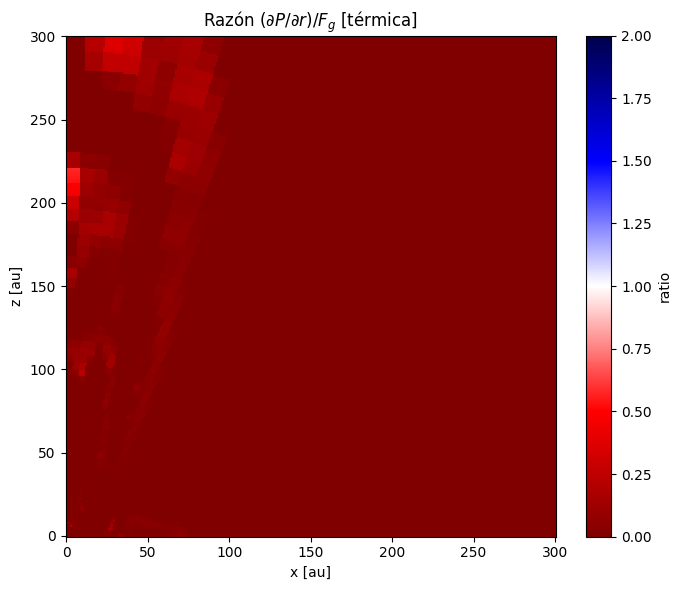

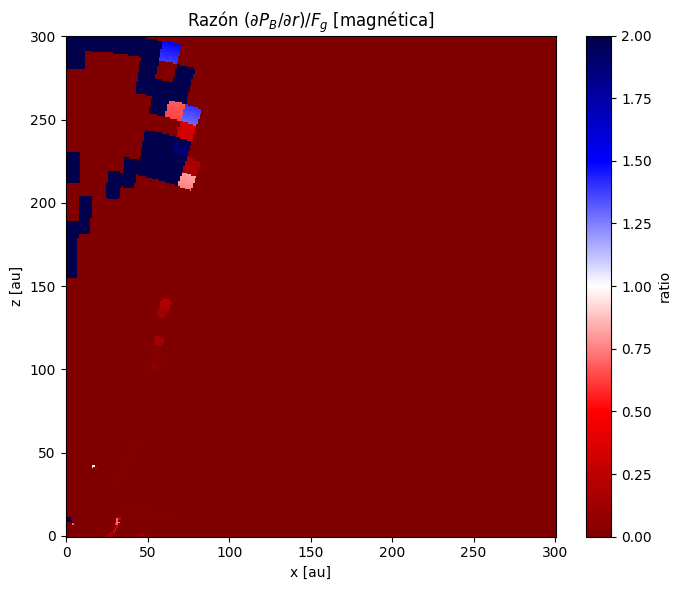

In [42]:
# Convert coordinates to cm to calculate radial distances
x_cm = x * AU_CM
z_cm = z * AU_CM
r2_cm2 = x_cm**2 + z_cm**2

# Estimate cell size to avoid division by zero near origin (r=0)
dx_au = find_min_step(x[:, 0]) if np.unique(x[:, 0]).size > 1 else find_min_step(x[0, :])
dz_au = find_min_step(z[0, :]) if np.unique(z[0, :]).size > 1 else find_min_step(z[:, 0])

r_min_cm = 0.5 * min(dx_au, dz_au) * AU_CM
r2_safe = np.where(r2_cm2 < r_min_cm**2, r_min_cm**2, r2_cm2)

# Gravitational force per unit volume
Fg = G * M_STAR * rho / r2_safe  # dyn/cm³

# Pressure to gravity ratios
ratio_th = Pgrad_r / Fg
ratio_mag = PBgrad_r / Fg

def plot_ratio(x, z, ratio, vmin, vmax, title):
    """Plot pressure/gravity ratio with appropriate colormap."""
    fig, ax = plt.subplots(figsize=(7, 6))
    pc = ax.pcolormesh(x, z, ratio, shading='auto', cmap='seismic_r', vmin=vmin, vmax=vmax)
    ax.set_xlabel('x [au]')
    ax.set_ylabel('z [au]')
    ax.set_title(title)
    cbar = fig.colorbar(pc, ax=ax)
    cbar.set_label('ratio')
    plt.tight_layout()
    plt.show()

plot_ratio(x, z, ratio_th, 0.0, 2.0, r'Razón $(\partial P/\partial r) / F_g$ [térmica]')
plot_ratio(x, z, ratio_mag, 0.0, 2.0, r'Razón $(\partial P_B/\partial r) / F_g$ [magnética]')


**Razón térmica**: El mapa muestra valores mayormente por debajo de 1 (tonos rojos). Esto indica que la presión térmica sola no es suficiente para contrarrestar la gravedad en la mayor parte del dominio.

**Razón magnética**: Aparecen zonas con valores superiores a 1 (tonos azules/blancos) principalmente cerca del eje superior (z grande). Estas regiones corresponden a lugares donde la fuerza magnética puede superar a la gravedad, lo cual es consistente con el canal de eyección del jet.

In [43]:
print("Resumen de razón (∂P/∂r) / Fg [térmica]")
razon_th_jet = calculate_region_stats(mask_jet, ratio_th, percentiles=[25, 50, 75])
razon_th_disc = calculate_region_stats(mask_disc, ratio_th, percentiles=[25, 50, 75])
razon_th_infall = calculate_region_stats(mask_infall, ratio_th, percentiles=[25, 50, 75])
print(f"✨ Jet   : n={razon_th_jet['n']:6d} | mediana={razon_th_jet['median']:8.6f} | Q25={razon_th_jet['p25']:8.6f} | Q75={razon_th_jet['p75']:8.6f}")
print(f"✨ Disco : n={razon_th_disc['n']:6d} | mediana={razon_th_disc['median']:8.6f} | Q25={razon_th_disc['p25']:8.6f} | Q75={razon_th_disc['p75']:8.6f}")
print(f"✨ Infall: n={razon_th_infall['n']:6d} | mediana={razon_th_infall['median']:8.6f} | Q25={razon_th_infall['p25']:8.6f} | Q75={razon_th_infall['p75']:8.6f}")

print("\nResumen de razón (∂P_B/∂r) / Fg [magnética]")
razon_mag_jet = calculate_region_stats(mask_jet, ratio_mag, percentiles=[25, 50, 75])
razon_mag_disc = calculate_region_stats(mask_disc, ratio_mag, percentiles=[25, 50, 75])
razon_mag_infall = calculate_region_stats(mask_infall, ratio_mag, percentiles=[25, 50, 75])
print(f"✨ Jet   : n={razon_mag_jet['n']:6d} | mediana={razon_mag_jet['median']:8.2f} | Q25={razon_mag_jet['p25']:8.2f} | Q75={razon_mag_jet['p75']:8.2f}")
print(f"✨ Disco : n={razon_mag_disc['n']:6d} | mediana={razon_mag_disc['median']:8.6f} | Q25={razon_mag_disc['p25']:8.6f} | Q75={razon_mag_disc['p75']:8.6f}")
print(f"✨ Infall: n={razon_mag_infall['n']:6d} | mediana={razon_mag_infall['median']:8.6f} | Q25={razon_mag_infall['p25']:8.6f} | Q75={razon_mag_infall['p75']:8.6f}")

Resumen de razón (∂P/∂r) / Fg [térmica]
✨ Jet   : n= 15977 | mediana=0.001190 | Q25=-0.039434 | Q75=0.077090
✨ Disco : n=  1219 | mediana=0.006860 | Q25=-0.056345 | Q75=0.038331
✨ Infall: n= 72804 | mediana=-0.034533 | Q25=-0.040756 | Q75=-0.029225

Resumen de razón (∂P_B/∂r) / Fg [magnética]
✨ Jet   : n= 15977 | mediana=  -25.93 | Q25=-1063.37 | Q75=   -1.05
✨ Disco : n=  1219 | mediana=-0.208107 | Q25=-0.906684 | Q75=-0.013488
✨ Infall: n= 72804 | mediana=-0.005431 | Q25=-0.012785 | Q75=-0.002056


Los resultados confirman que el jet tiene origen magnético. Encontramos regiones donde la razón magnética supera la unidad (valores >1), especialmente cerca del eje z, lo que significa que la presión magnética puede igualar o incluso superar a la gravedad en esas zonas.

Por el contrario, la presión térmica muestra razones consistentemente menores a 1 en prácticamente todo el dominio. Esto sugiere que la presión térmica sola no puede explicar la eyección del jet ni contrarrestar el colapso gravitacional general del sistema.

## ⭐ Problema 4

Análisis de datos en la tabla temporal

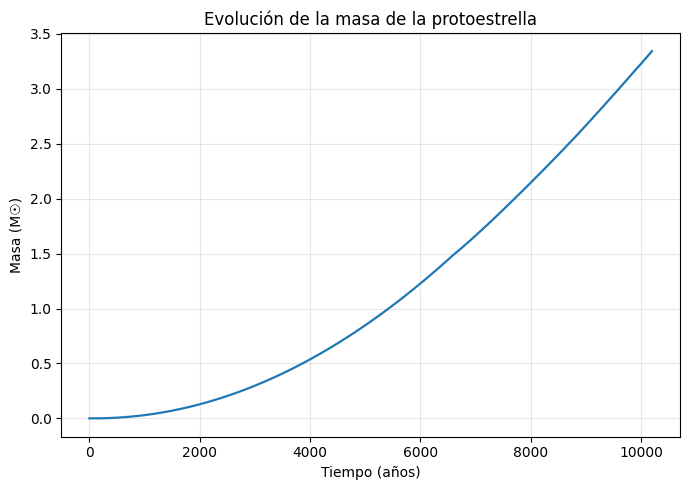

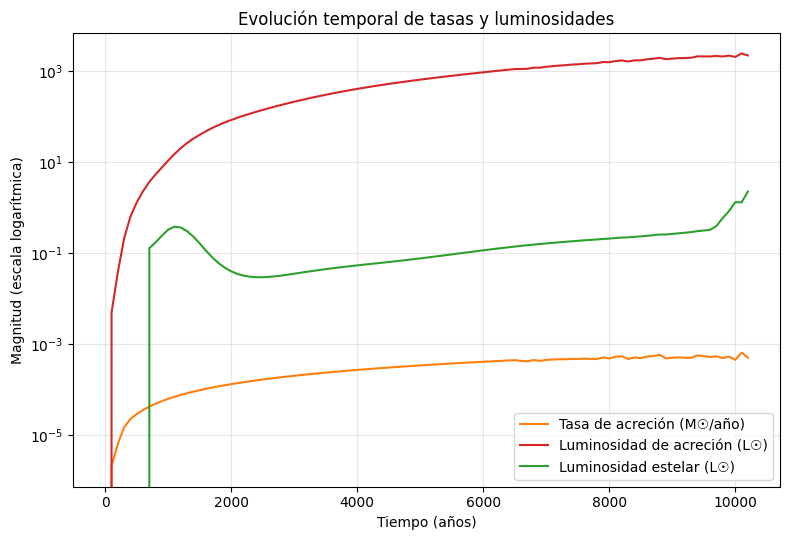

In [44]:
# Extract columns from table
t = table[:, 0]      # time [years]
M = table[:, 1]      # mass [Msol]
Mdot = table[:, 2]   # accretion rate [Msol/year]
Lacc = table[:, 3]   # accretion luminosity [Lsol]
Lstar = table[:, 4]  # stellar luminosity [Lsol]

# Plot mass evolution
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(t, M, color='tab:blue', lw=1.6)
ax.set_xlabel("Tiempo (años)")
ax.set_ylabel("Masa (M☉)")
ax.set_title("Evolución de la masa de la protoestrella")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot rates and luminosities
fig, ax = plt.subplots(figsize=(8, 5.5))
ax.plot(t, Mdot, label="Tasa de acreción (M☉/año)", color='tab:orange', lw=1.5)
ax.plot(t, Lacc, label="Luminosidad de acreción (L☉)", color='tab:red', lw=1.5)
ax.plot(t, Lstar, label="Luminosidad estelar (L☉)", color='tab:green', lw=1.5)
ax.set_yscale('log')
ax.set_xlabel("Tiempo (años)")
ax.set_ylabel("Magnitud (escala logarítmica)")
ax.set_title("Evolución temporal de tasas y luminosidades")
ax.grid(alpha=0.3, which='both')
ax.legend(frameon=True)
plt.tight_layout()
plt.show()


In [45]:
# Calculate accretion rate statistics
mask_finite = np.isfinite(Mdot) & (Mdot > 0)
mdot_med = np.median(Mdot[mask_finite])
mdot_min = np.min(Mdot[mask_finite])
mdot_max = np.max(Mdot[mask_finite])

oom_med = order_of_magnitude(mdot_med)
oom_min = order_of_magnitude(mdot_min)
oom_max = order_of_magnitude(mdot_max)

# Fraction of time where Lacc > Lstar
frac_Lacc_gt_Lstar = np.mean(Lacc > Lstar)

print(f"✨ Tasa de acreción mediana  = {mdot_med:.2e} M☉/año  (~{oom_med:.0e})")
print(f"✨ Tasa de acreción mínima   = {mdot_min:.2e} M☉/año  (~{oom_min:.0e})")
print(f"✨ Tasa de acreción máxima   = {mdot_max:.2e} M☉/año  (~{oom_max:.0e})")
print(f"✨ Fracción de tiempo con Lacc > Lstar = {frac_Lacc_gt_Lstar:.2%}")

✨ Tasa de acreción mediana  = 3.56e-04 M☉/año  (~1e-04)
✨ Tasa de acreción mínima   = 2.12e-06 M☉/año  (~1e-06)
✨ Tasa de acreción máxima   = 6.59e-04 M☉/año  (~1e-04)
✨ Fracción de tiempo con Lacc > Lstar = 99.03%


La masa crece de manera monótona con el tiempo, confirmando que hay acreción continua sobre la protoestrella.

La tasa de acreción tiene un orden de magnitud típico alrededor de 10⁻⁴ M☉/año. La mediana es aproximadamente 3.6×10⁻⁴ M☉/año, con valores que van desde ~2×10⁻⁶ hasta ~6.6×10⁻⁴ M☉/año.

Respecto a las luminosidades, L_acc supera a L_star durante aproximadamente el 99% del tiempo (fracción del 99.03%). Esto indica que la protoestrella se encuentra todavía en una fase donde la energía proveniente de la acreción domina sobre la luminosidad intrínseca de la estrella.